In [1]:
# generate random points
from math import pi
from numpy import sin, cos
from numpy.random import random

N = 5000

X = random((N*2, 2))
X = X[X[..., 1] < sin(X[..., 0]*pi)][:N, ...]
X[..., 0] = pi * (X[..., 0] - 0.5)
X[..., 1] = pi*(2.0*X[..., 1] / cos(X[..., 0]) - 1.0)
X *= 180./pi
lats = X[..., 0]
lons = X[..., 1]

In [2]:
#generate times
from numpy import linspace
times = linspace(2010, 2020, 250 + 1)

In [3]:
#calculate change rate
from apexpy import Apex
from numpy import empty, sqrt, arccos

def geo2qd(time, lats, lons, height=0):
    apex = Apex(time)
    return apex.geo2qd(lats, lons, height)

def ll2xyz(lats, lons):
    deg2rad = pi/180.
    lats = deg2rad * lats
    lons = deg2rad * lons
    cos_lons = cos(lons)
    return (
            cos(lats)*cos_lons,
            sin(lats)*cos_lons,
            sin(lons), 
    )

def distance_sph(lats0, lons0, lats1, lons1):
    x0, y0, z0 = ll2xyz(lats0, lons0)
    x1, y1, z1 = ll2xyz(lats1, lons1)
    return arccos(x0*x1 + y0*y1 + z0*z1) * (180/pi)
    
def distance_cart(lats0, lons0, lats1, lons1):
     return sqrt((lats1 - lats0)**2 + (lons1 - lons0)**2)
    
def calculate_temporal_change(time, lats, lons, distance=distance_sph, eps=1e-2):
    qdlats0, qdlons0 = geo2qd(time - eps, lats, lons)
    qdlats1, qdlons1 = geo2qd(time, lats, lons)
    return distance(qdlats0, qdlons0, qdlats1, qdlons1) / eps


In [4]:
from datetime import datetime
from numpy import meshgrid

# spherical GEO coordinates - longitude [deg], latitude [deg]
#lat_step, lon_step = .1, .1 # deg
lat_step, lon_step = 0.5, 0.5 # deg
eps = 1e-3    
lons2d, lats2d = meshgrid(
    linspace(-180, 180, 1 + int(360./lon_step)),
    linspace(-90+eps, 90-eps, 1 + int(180./lat_step))
)


change2d = calculate_temporal_change(2018.0, lats2d, lons2d, distance=distance_sph)
print lons2d.shape
print lats2d.shape
print change2d.shape


(361, 721)
(361, 721)
(361, 721)


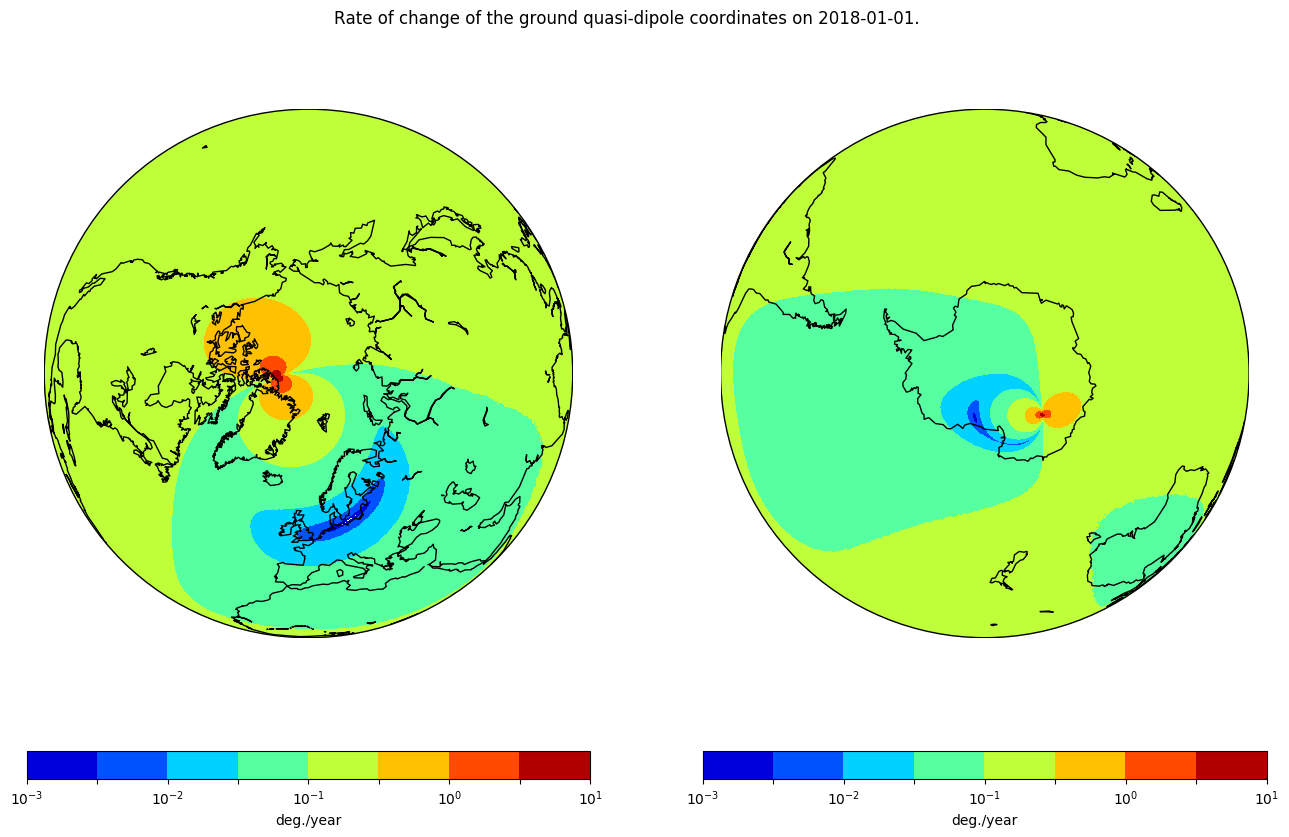

In [8]:
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

fig=plt.figure(figsize=(16, 10), dpi=100, facecolor='w', edgecolor='k')


def decorate_map(map):
    map.drawcoastlines(color='k')

def plot_data(map, lats, lons, data, **opts):
    #obj = map.pcolor(lons, lats, data, latlon=True, **opts)
    obj = map.contourf(
        lons, lats, data,
        norm=colors.LogNorm(),
        cmap='jet',
        levels=[0.001, 0.0031623, 0.01, 0.031623, 0.1, 0.31623, 1.0, 3.1623, 10.],
        latlon=True,
        **opts
    )
    cbar = plt.colorbar(obj, orientation="horizontal")
    cbar.ax.set_xlabel("deg./year")

def plot_data2(map, lats, lons, data, **opts):
    obj = map.pcolor(
            lons, lats, data, latlon=True,
            vmin=0.001, vmax=10., norm=colors.LogNorm(),
            **opts
    )
    cbar = plt.colorbar(obj, orientation="horizontal")
    cbar.ax.set_xlabel("deg./year")

plt.suptitle("Rate of change of the ground quasi-dipole coordinates on 2018-01-01.")


plt.subplot(121)
map = Basemap(projection='ortho', lon_0=0, lat_0=90)
decorate_map(map)
plot_data(map, lats2d, lons2d, change2d)

plt.subplot(122)
map = Basemap(projection='ortho', lon_0=0, lat_0=-90)
decorate_map(map)
plot_data(map, lats2d, lons2d, change2d)

plt.show()

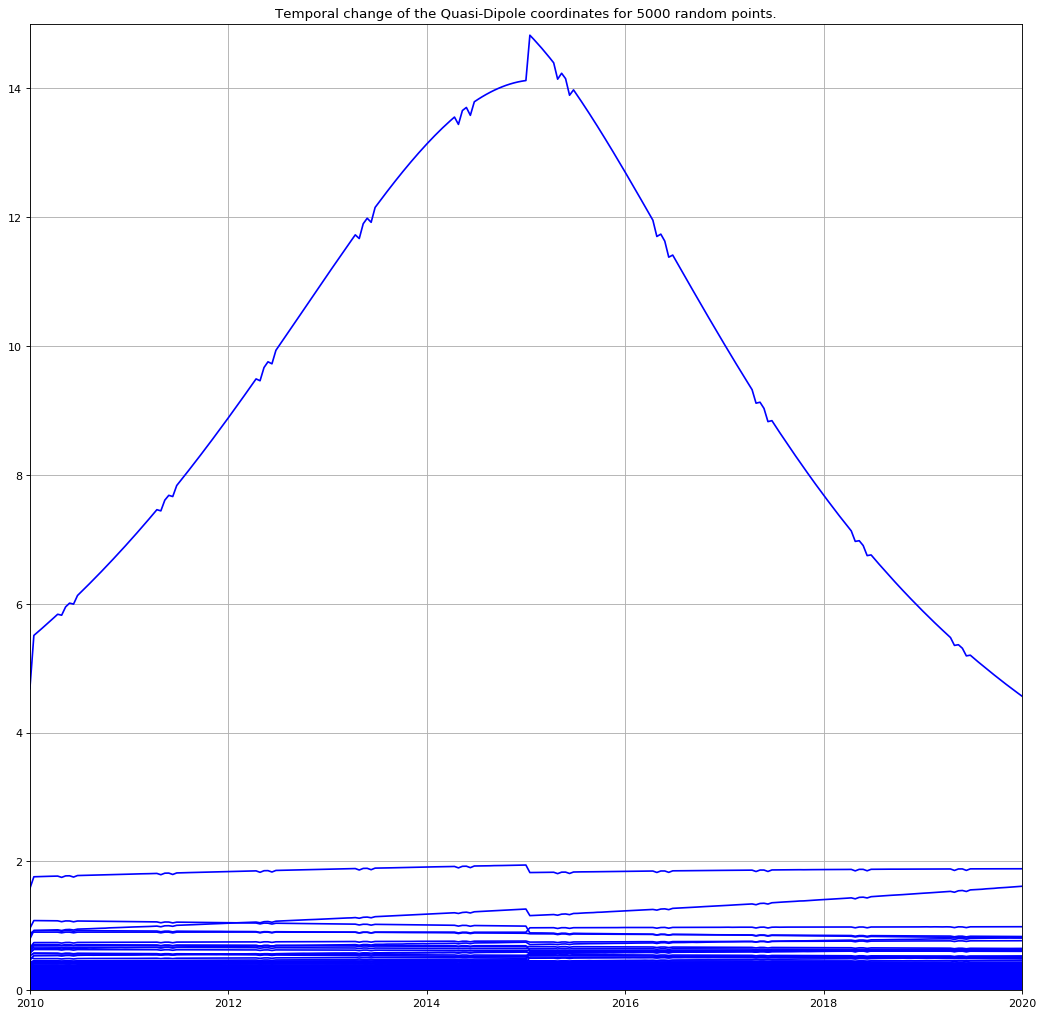

In [6]:
from matplotlib import pyplot as plt
from itertools import izip
from math import ceil

changes_sph = empty((len(X), len(times)))
changes_cart = empty((len(X), len(times)))

for idx, time in enumerate(times):
    changes_sph[:, idx] = calculate_temporal_change(time, lats, lons, distance_sph)
    changes_cart[:, idx] = calculate_temporal_change(time, lats, lons, distance_cart)

fig=plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
for point_profile_sph, point_profile_cart in izip(changes_sph, changes_cart):
    #plt.plot(times, point_profile_cart, 'g')
    plt.plot(times, point_profile_sph, 'b')
plt.axis([min(times), max(times), 0, ceil(changes_sph.max())])
plt.title("Temporal change of the Quasi-Dipole coordinates for %d random points." % N)
plt.grid()
plt.show();

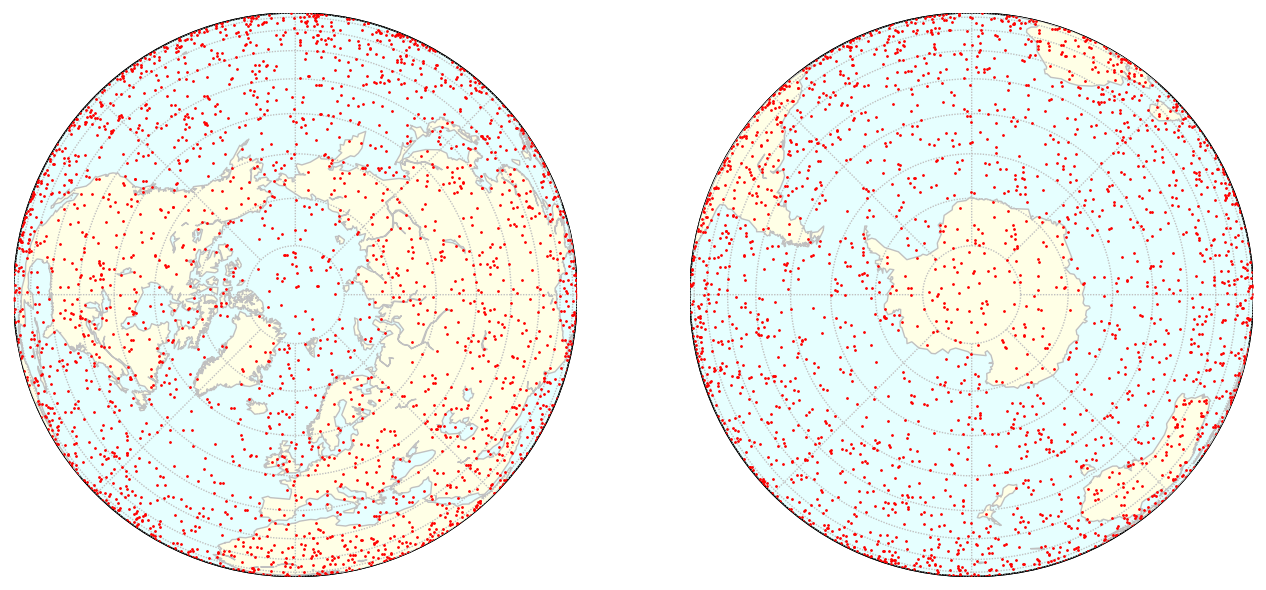

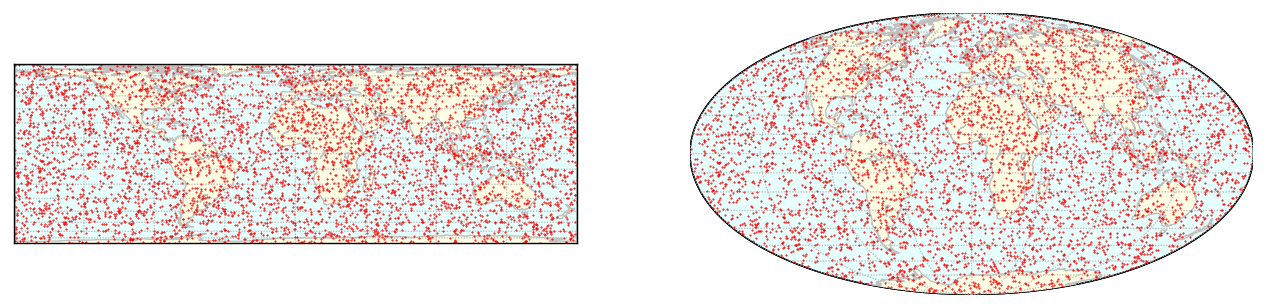

In [9]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

def decorate_map(map):
    map.drawcoastlines(color="silver")
    map.fillcontinents(color=(1.0, 1.0, 0.9), lake_color=(0.9, 1.0, 1.0))
    map.drawmapboundary(fill_color=(0.9, 1.0, 1.0))
    map.drawmeridians([-135, -90, -45, 0, 45, 90, 135, 180], color="silver")
    map.drawparallels([-70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70], color="silver")

def plot_points(map, lats, lons):
    x, y = map(lons, lats)
    return map.plot(x, y, 'r.', markersize=2)

fig=plt.figure(figsize=(16, 16), dpi= 100, facecolor='w', edgecolor='silver')

plt.subplot(121)
map = Basemap(projection='ortho', lon_0=0, lat_0=90)
decorate_map(map)
plot_points(map, lats, lons)

plt.subplot(122)
map = Basemap(projection='ortho', lon_0=0, lat_0=-90)
decorate_map(map)
plot_points(map, lats, lons)

fig=plt.figure(figsize=(16, 16), dpi= 100, facecolor='w', edgecolor='silver')

def plot_points(map, lats, lons):
    x, y = map(lons, lats)
    return map.plot(x, y, 'r.', markersize=1)

plt.subplot(121)
map = Basemap(projection='cea', lon_0=0)
decorate_map(map)
plot_points(map, lats, lons)

plt.subplot(122)
map = Basemap(projection='moll',lon_0=0)
decorate_map(map)
plot_points(map, lats, lons)


plt.show()